# Bidirectional model predictive control study

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [2]:
from utils.step_reference import gen_step_ref
from dyn.linear_long import LinearLong
from alg.sparse_quad_pfmpc import SparseQuadPFMPC
from alg.sparse_quad_bdmpc import SparseQuadBDMPC

### Platoon parameters

In [3]:
H = 50    # planning horizon
N = 50     # number of vehicles in platoon, including leader
dt = 0.1  # timestep
total_time = 10.0  # seconds
total_time += dt * H
d_des = 5   # desired spacing

# dynamics stuff
x_min = np.array([-np.inf, -np.inf, -np.inf])
x_max = np.array([np.inf, np.inf, np.inf])
u_min = np.array([-6.0])
u_max = np.array([6.0])
tau = 0.5
dyn = LinearLong(dt, x_min, x_max, u_min, u_max, tau)
m = dyn.m
n = dyn.n
p = dyn.p

# pf mpc
q = 10
q_p = 10
r = .1
Q = q * np.eye(p)
Q_p = q_p * np.eye(p)
R = r * np.eye(m)
pfmpc = SparseQuadPFMPC(Q, Q_p, R, dyn, u_min, u_max, H)

# bd mpc
q = 10
q_p = 5
q_s = 5
r = .1
Q = q * np.eye(p)
Q_p = q_p * np.eye(p)
Q_s = q_s * np.eye(p)
R = r * np.eye(m)
bdmpc = SparseQuadBDMPC(Q, Q_p, Q_s, R, dyn, u_min, u_max, H)

### Reference trajectory - Acceleration

In [5]:
dist_start = 1.0
dist_end = 2.0
v_start = 20.
v_end = 22.

x_ref, t_range = gen_step_ref(total_time, dt, dist_start, dist_end, 
                              v_start, v_end)
y_ref = x_ref[:2, :]
T = len(t_range)
t_range_mpc = t_range[:T-H]

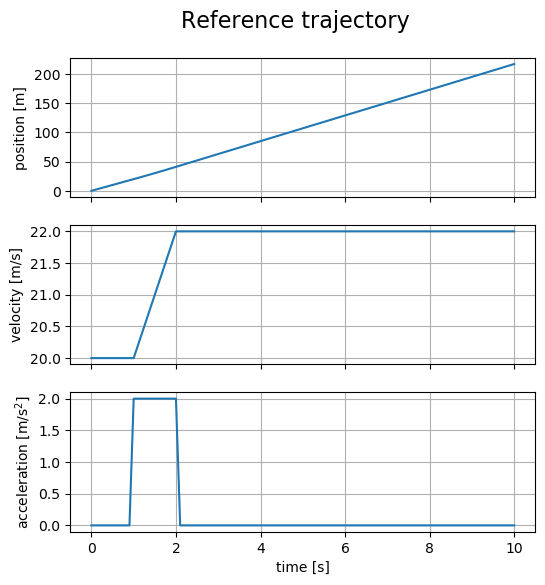

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
fig.suptitle("Reference trajectory", size=16)
fig.subplots_adjust(top=0.9)

for i in range(x_ref.shape[0]):
    ax[i].plot(t_range[:T-H], x_ref[i, :T-H])
    ax[i].grid()
ax[0].set_ylabel("position [m]")
ax[1].set_ylabel("velocity [m/s]")
ax[2].set_ylabel(r"acceleration [m/s$^2$]")
ax[2].set_xlabel("time [s]");

## Bidirectional platoon analysis

In [7]:
x_bdmpc = [np.zeros((dyn.n, T-H)) for _ in range(N + 1)]
u_bdmpc = [np.zeros((dyn.m, T-H-1)) for _ in range(N + 1)]

# zeroth vehicle is virtual leader
x_bdmpc[0] = x_ref[:, :T-H]
u_bdmpc[0][:, :T-H-1] = x_ref[2, :T-H-1]

# initial condition: start in correct place with desired spacing, velocity, and 
# acceleration
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    x_bdmpc[i][:, 0] = np.array([-(i-1)*d, x_bdmpc[0][1, 0], x_bdmpc[0][2, 0]])

# initialize assumed states, controls, and output for first timestep
x_a_bdmpc = [np.zeros((dyn.n, H + 1)) for _ in range(N + 1)]
x_a_bdmpc[0] = x_bdmpc[0][:, :H+1]
for i in range(1, N + 1):
    x_a_bdmpc[i][:, 0] = x_bdmpc[i][:, 0]

y_a_bdmpc = [np.zeros((dyn.p, H + 1)) for _ in range(N + 1)]
y_a_bdmpc[0] = x_bdmpc[0][:2, :H+1]
for i in range(1, N + 1):
    y_a_bdmpc[i][:, 0] = dyn.sense(x_a_bdmpc[i][:, 0])

u_a_bdmpc = [np.zeros((dyn.m, H)) for _ in range(N + 1)]
u_a_bdmpc[0] = u_bdmpc[0][:H]

for i in range(1, N+1):
    for k in range(H):
        x_a_bdmpc[i][:, k+1] = dyn.forward(x_a_bdmpc[i][:, k], u_a_bdmpc[i][:, k])
        y_a_bdmpc[i][:, k+1] = dyn.sense(x_a_bdmpc[i][:, k+1])

x_a_bdmpc_prev = copy.deepcopy(x_a_bdmpc)
y_a_bdmpc_prev = copy.deepcopy(y_a_bdmpc)
u_a_bdmpc_prev = copy.deepcopy(u_a_bdmpc)

In [8]:
start_time = time.time()
no_soln = False
for k in tqdm(range(T - H - 1)):
    for i in range(1, N + 1):
        x_0 = x_bdmpc[i][:, k]
        y_a = y_a_bdmpc_prev[i]
        y_pred_a = y_a_bdmpc_prev[i-1]
        d_pred = 0 if i == 1 else d_des
        if i > 1 and i < N:
            y_succ_a = y_a_bdmpc_prev[i+1]
            d_succ = d_des

        x_opt = np.zeros((n, H+1))
        u_opt = np.zeros((m, H))
        y_opt = np.zeros((p, H+1))

        if i == 1 or i == N:
            z_opt, prob = pfmpc.control(x_0, y_a, y_pred_a, d_pred)
            if prob.status != 'optimal':
                print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
                print(f"d_pred = {d_pred}")
                no_soln = True
                break

            x_opt[:, 0] = x_0
            u_opt[:, 0] = z_opt[:m]
            y_opt[:, 0] = z_opt[m:m+p]
            for t, j in enumerate(range(m+p, len(z_opt), n+m+3*p)):
                x_opt[:, t+1] = z_opt[j:j+n]
                u_opt[:, t+1] = z_opt[j+n:j+n+m]
                y_opt[:, t+1] = z_opt[j+n+m:j+n+m+p]
            x_opt[:, H] = dyn.forward(x_opt[:, H-1], u_opt[:, H-1])
            y_opt[:, H] = dyn.sense(x_opt[:, H])

        else:
            z_opt, prob = bdmpc.control(x_0, y_a, y_pred_a, y_succ_a, d_succ)
            if prob.status != 'optimal':
                print(f"timestep {k}, vehicle {i}, problem returned: {prob.status}")
                no_soln = True
                break

            x_opt[:, 0] = x_0
            u_opt[:, 0] = z_opt[:m]
            y_opt[:, 0] = z_opt[m:m+p]
            for t, j in enumerate(range(m+p, len(z_opt), n+m+4*p)):
                x_opt[:, t+1] = z_opt[j:j+n]
                u_opt[:, t+1] = z_opt[j+n:j+n+m]
                y_opt[:, t+1] = z_opt[j+n+m:j+n+m+p]
            x_opt[:, H] = dyn.forward(x_opt[:, H-1], u_opt[:, H-1])
            y_opt[:, H] = dyn.sense(x_opt[:, H])

        u_bdmpc[i][:, k] = u_opt[:, 0]
        x_bdmpc[i][:, k+1] = dyn.forward(x_0, u_opt[:, 0])

        # update assumed state, control, input
        u_a_bdmpc[i][:, :H-1] = u_opt[:, 1:H]
        u_a_bdmpc[i][:, H-1] = np.zeros((dyn.m))
        x_a_bdmpc[i][:, 0] = x_opt[:, 1]
        y_a_bdmpc[i][:, 0] = dyn.sense(x_a_bdmpc[i][:, 0])
        for t in range(H):
            x_a_bdmpc[i][:, t+1] = dyn.forward(x_a_bdmpc[i][:, t], u_a_bdmpc[i][:, t])
            y_a_bdmpc[i][:, t+1] = dyn.sense(x_a_bdmpc[i][:, t+1])

    if no_soln:
        fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
        fig.suptitle(f"timestep {k}, vehicle {i} failure", size=16)
        fig.subplots_adjust(top=0.9)
        for i in range(N+1):
            ax[0].plot(t_range[:H+1], y_a_bdmpc_prev[i][0, :], 
                       label=f"{i} assumed")
            ax[1].plot(t_range[:H+1], y_a_bdmpc_prev[i][1, :], 
                       label=f"{i} assumed")
        ax[0].set_ylabel("position [m]")
        ax[0].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        ax[1].set_ylabel("velocity [m/s]")
        ax[1].set_xlabel("time [s]")
        ax[1].legend(bbox_to_anchor=(1.02, 0.5), loc='center left')
        break
    
    x_a_bdmpc[0] = x_ref[:, k+1:k+H+2]
    y_a_bdmpc[0] = x_ref[:2, k+1:k+H+2]
    u_a_bdmpc[0] = x_ref[2, k+1:k+H+1]

    x_a_bdmpc_prev = copy.deepcopy(x_a_bdmpc)
    y_a_bdmpc_prev = copy.deepcopy(y_a_bdmpc)
    u_a_bdmpc_prev = copy.deepcopy(u_a_bdmpc)

end_time = time.time()
avg_time = (end_time - start_time) / (N * (T - H))

100%|██████████| 100/100 [00:26<00:00,  3.82it/s]


In [9]:
print(f"\nbd-mpc average time: {1 / avg_time} Hz")


bd-mpc average time: 193.12308731649648 Hz


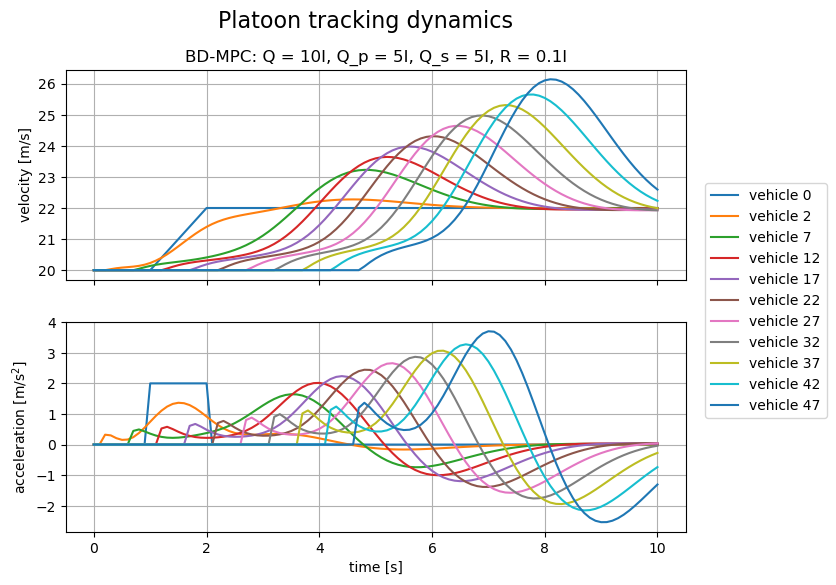

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon tracking dynamics", size=16)
ax[0].set_title(f"BD-MPC: Q = {q}I, Q_p = {q_p}I, Q_s = {q_s}I, R = {r}I")
fig.subplots_adjust(top=0.88)

ax[0].plot(t_range_mpc, x_bdmpc[0][1, :], label=f"vehicle 0")
ax[1].plot(t_range_mpc, x_bdmpc[0][2, :], label=f"vehicle 0")
for i in range(2, N + 1, round(N / 10)):
    ax[0].plot(t_range_mpc, x_bdmpc[i][1, :], label=f"vehicle {i}")
    ax[1].plot(t_range_mpc, x_bdmpc[i][2, :], label=f"vehicle {i}")

ax[0].set_ylabel("velocity [m/s]")
ax[1].set_ylabel(r"acceleration [m/s$^2$]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(1.02, -0.1), loc="center left")

In [11]:
d_error_bdmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_bdmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = (i-1) * d_des
    d_error_bdmpc[i] = x_bdmpc[i][0, :] - x_bdmpc[0][0, :] + d
    v_error_bdmpc[i] = x_bdmpc[i][1, :] - x_bdmpc[0][1, :]

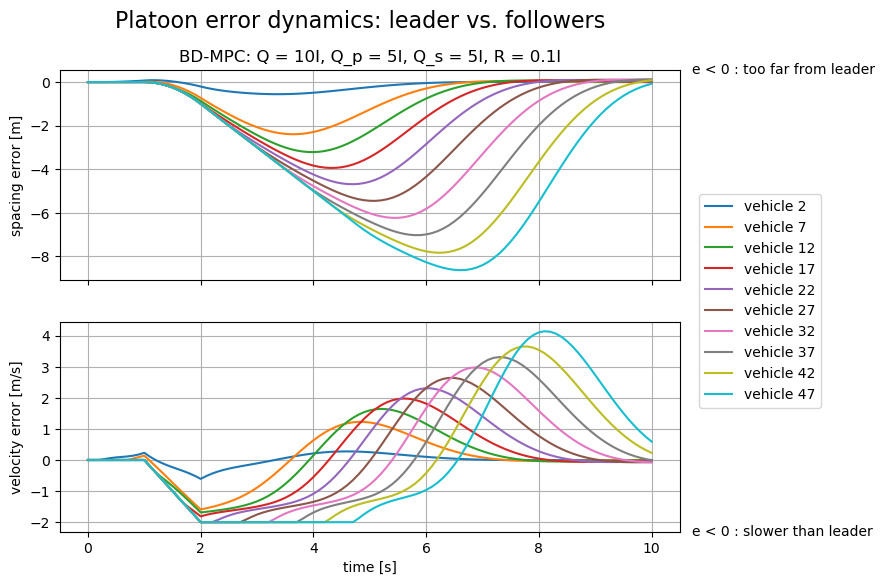

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: leader vs. followers", size=16)
ax[0].set_title(f"BD-MPC: Q = {q}I, Q_p = {q_p}I, Q_s = {q_s}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(2, N + 1, round(N / 10)):
    ax[0].plot(t_range[:T-H], d_error_bdmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_bdmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from leader", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than leader", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")

In [13]:
d_error_bdmpc = [np.zeros(T-H) for _ in range(N + 1)]
v_error_bdmpc = [np.zeros(T-H) for _ in range(N + 1)]
for i in range(1, N + 1):
    d = 0 if i == 1 else d_des
    d_error_bdmpc[i] = x_bdmpc[i][0, :] - x_bdmpc[i-1][0, :] + d
    v_error_bdmpc[i] = x_bdmpc[i][1, :] - x_bdmpc[i-1][1, :]

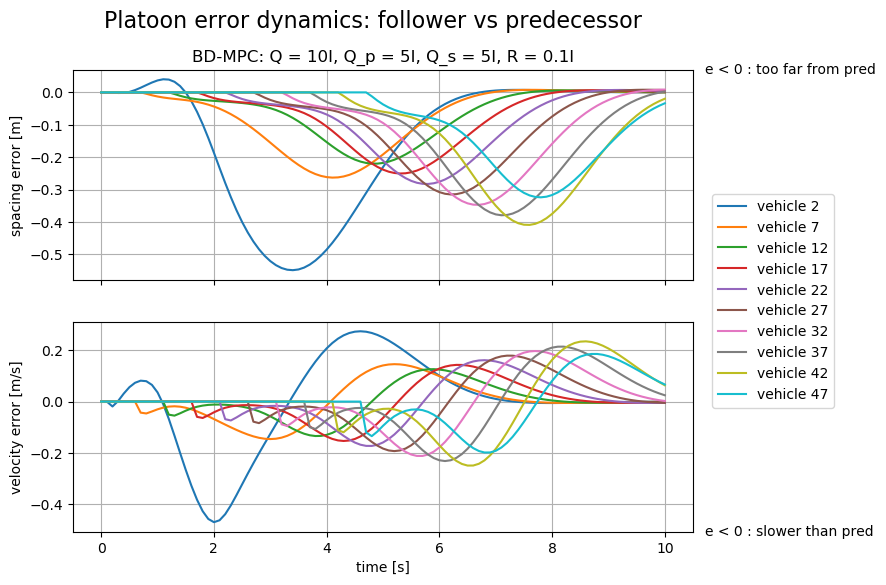

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.suptitle("Platoon error dynamics: follower vs predecessor", size=16)
ax[0].set_title(f"BD-MPC: Q = {q}I, Q_p = {q_p}I, Q_s = {q_s}I, R = {r}I")
fig.subplots_adjust(top=0.88)

for i in range(2, N + 1, round(N / 10)):
    ax[0].plot(t_range[:T-H], d_error_bdmpc[i], label=f"vehicle {i}")
    ax[1].plot(t_range[:T-H], v_error_bdmpc[i], label=f"vehicle {i}")

ax[0].text(1.02, 1.0, "e < 0 : too far from pred", va='center', 
           transform=ax[0].transAxes)
ax[1].text(1.02, 0.0, "e < 0 : slower than pred", va='center', 
           transform=ax[1].transAxes)

ax[0].set_ylabel("spacing error [m]")
ax[1].set_ylabel("velocity error [m/s]")
ax[1].set_xlabel("time [s]")
ax[0].grid()
ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.02, 1.1), loc="center left")